In [1]:
import functools
import numpy as np
import pandas as pd
import random
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from simulation import run_simulation
from data_provider import get_sign_dataset, get_feature_columns

In [2]:
X_train, y_train, X_test, y_test, X_wc, y_wc = get_sign_dataset()

Dataset length 39009
Dataset complete cases length 6676
Whole train set length:  5601
Whole test set length:  1075
Whole WC set length:  128


<Figure size 1440x432 with 0 Axes>

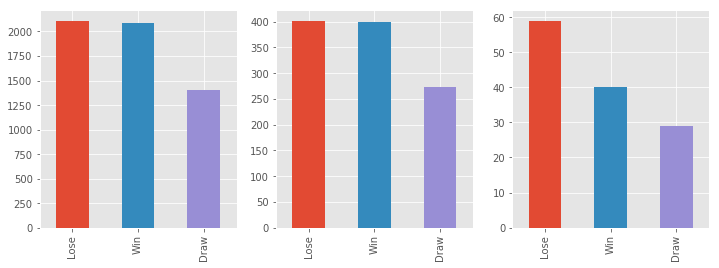

In [3]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

In [4]:
#plt.figure(figsize=(10,10))
#plt.matshow(X_train.corr(), fignum=1)
#X_train.corr()

In [5]:
def get_feature_importance(clf):
    zipped = sorted(zip(get_feature_columns(), clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [21]:
def run_grid_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      custom_report_for_model=None):
    random_search = GridSearchCV(clf, param_grid=param_dist)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)
    return best_clf

In [24]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

param_dist = {"n_estimators": [1000],
              "max_depth": [None],
              "min_samples_leaf": [7],
              "max_features": ["sqrt"],
              "criterion": ["gini"]}
best_clf = run_grid_search(clf, param_dist,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance)

TRAIN SET METRICS:
SCORE:  0.850562399572
             precision    recall  f1-score   support

       -1.0       0.83      0.90      0.86      2111
        0.0       0.98      0.69      0.81      1402
        1.0       0.82      0.90      0.86      2088

avg / total       0.86      0.85      0.85      5601

BEST PARAMS:  {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 1000}


TEST SET METRICS:
SCORE:  0.536744186047

              precision    recall  f1-score   support

       -1.0       0.52      0.73      0.61       402
        0.0       0.28      0.04      0.06       274
        1.0       0.57      0.68      0.62       399

avg / total       0.48      0.54      0.48      1075



WC SET METRICS:
SCORE:  0.59375

              precision    recall  f1-score   support

       -1.0       0.65      0.76      0.70        59
        0.0       0.00      0.00      0.00        29
        1.0       0.53      0.78      0.63        40

avg

In [32]:
run_simulation(best_clf)




___Group Stage___

Russia - Saudi Arabia: 1 -- PROBAS -- [ 0.21897278  0.27171602  0.5093112 ]
Egypt - Uruguay: -1 -- PROBAS -- [ 0.53250126  0.29183807  0.17566067]
Morocco - IR Iran: -1 -- PROBAS -- [ 0.46743975  0.21068867  0.32187158]
Portugal - Spain: -1 -- PROBAS -- [ 0.40542044  0.31355911  0.28102046]
France - Australia: 1 -- PROBAS -- [ 0.14484859  0.21246531  0.6426861 ]
Argentina - Iceland: 1 -- PROBAS -- [ 0.15546302  0.19199757  0.65253941]
Peru - Denmark: -1 -- PROBAS -- [ 0.36566675  0.27895651  0.35537673]
Croatia - Nigeria: 1 -- PROBAS -- [ 0.19686083  0.26377046  0.53936871]
Costa Rica - Serbia: -1 -- PROBAS -- [ 0.4229137   0.36183168  0.21525462]
Germany - Mexico: 1 -- PROBAS -- [ 0.10963424  0.18405404  0.70631173]
Brazil - Switzerland: 1 -- PROBAS -- [ 0.17490059  0.22029463  0.60480478]
Sweden - Korea Republic: 1 -- PROBAS -- [ 0.31036406  0.26900361  0.42063233]
Belgium - Panama: 1 -- PROBAS -- [ 0.04653621  0.1158619   0.83760188]
Tunisia - England: -1 -- PR